In [8]:
import numpy as np
import pandas as pd
import datetime
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=15)

# 今回使用するモデル
観測方程式 :   
　$y_t = x_{t} +  \epsilon_t, \hspace{10pt}\epsilon_t\sim N(0,H_t)$  
状態方程式 :   
　$x_{t} = T_t x_{t-1} + A\cdot\exp\left(\frac{B}{z}\right) + \eta_{t}, \hspace{10pt}\eta_{t}\sim N(0,Q_t)$

# テスト用サンプルデータ作成

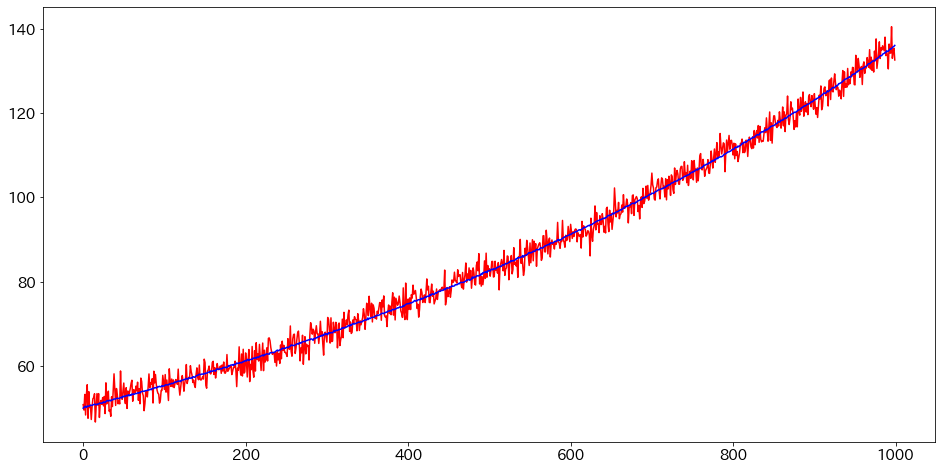

In [120]:
def gen_data_for_model1():
    nobs = 1000

    rs = np.random.RandomState(seed=93572)

    Ht = 5
    Tt = 1.001
    A = 0.1
    B = -0.007
    Qt = 0.01
    var_z = 0.1

    et = rs.normal(scale=Ht**0.5, size=nobs)
    z = np.cumsum(rs.normal(size=nobs, scale=var_z**0.05))
    Et = rs.normal(scale=Qt**0.5, size=nobs)

    xt_1 = 50
    x = []
    
    for i in range(nobs):
        xt = Tt * xt_1
        x.append(xt)
        xt_1 = xt
    xt = np.array(x)
    xt = xt + A * np.exp(B/z) + Et
    yt = xt + et
    
    return yt, xt, z



yt, xt, z = gen_data_for_model1()
_ = plt.plot(yt,color = "r")
_ = plt.plot(xt, color="b")

# データをDataFrameに格納し、予測をするためにindexをdatetimeにする

In [121]:
df = pd.DataFrame()
df['y'] = yt
df['x'] = xt
df['z'] = z
df

,y,x,z
0,50.848548,50.015376,-0.366067
1,49.572194,50.167559,-1.666142
2,53.271623,50.429264,-2.789351
3,48.397776,50.428109,-2.554394
4,53.225131,50.182709,-1.945448
...,...,...,...
995,140.524005,135.410260,19.920777
996,133.012583,135.494925,20.499302
997,134.607308,135.779538,20.972063
998,135.415238,135.853191,21.301890


In [122]:
st = datetime.datetime.strptime("2001/1/1 0:00", '%Y/%m/%d %H:%M')
date = []
for i in range(1000):
    if i == 0:
        d = st
    dt = d.strftime('%Y/%m/%d %H:%M')
    date.append(dt)
    d += datetime.timedelta(days=1)
df['date'] = date
df['date'] = pd.to_datetime(df['date'] )
df = df.set_index("date")
df

,y,x,z
date,,,
2001-01-01,50.848548,50.015376,-0.366067
2001-01-02,49.572194,50.167559,-1.666142
2001-01-03,53.271623,50.429264,-2.789351
2001-01-04,48.397776,50.428109,-2.554394
2001-01-05,53.225131,50.182709,-1.945448
...,...,...,...
2003-09-23,140.524005,135.410260,19.920777
2003-09-24,133.012583,135.494925,20.499302
2003-09-25,134.607308,135.779538,20.972063


In [5]:
df.to_csv("df.csv")

In [6]:
df = pd.read_csv("df.csv", index_col=0, parse_dates=['date'])
df

,y,x,z
date,,,
2001-01-01,-0.344441,-11.744802,0.034190
2001-01-02,1.992783,1.348933,-0.043086
2001-01-03,4.012891,12.529722,-0.204146
2001-01-04,0.900000,-15.917885,-0.409081
2001-01-05,1.912473,1.486223,-0.311952
...,...,...,...
2003-09-23,1.551433,22.266348,3.290859
2003-09-24,-2.518024,-7.187705,3.455083
2003-09-25,1.373850,-18.871977,3.343562


# モデル定義

In [123]:
class custom(sm.tsa.statespace.MLEModel):
    param_names = ['T', 'A', 'B', 'Ht', 'Qt']
    start_params = [1., 1., 0., 1., 1]

    def __init__(self, endog, exog):
        exog = np.squeeze(exog)
        super().__init__(endog, exog=exog, k_states=1, initialization='diffuse')
        self.k_exog = 1
        
        # Z = I
        self['design', 0, 0] = 1.
        # R = I
        self['selection', 0, 0] = 1.
        
        # Set c_t to be time-varying
        self['state_intercept'] = np.zeros((1, self.nobs))
        
    def clone(self, endog, exog, **kwargs):
        return self._clone_from_init_kwds(endog, exog=exog, **kwargs)
        
    def transform_params(self, params):
        # Variances must be positive
        params[3:] = params[3:]**2
        return params
        
    def untransform_params(self, params):
        # Reverse of above transformation
        params[3:] = params[3:]**0.5
        return params
    
    def update(self, params, **kwargs):
        params = super().update(params, **kwargs)
        # T = T
        self['transition', 0, 0] = params[0] 
        # c_t = A * exp(B / z_t)
        self['state_intercept', 0, :] = params[1] * np.exp(params[2] / self.exog)       
        # Ht
        self['obs_cov', 0, 0] = params[3]
        # Qt
        self['state_cov', 0, 0] = params[4]

# 推定用データと予測用データに分ける

In [124]:
df_test = df.iloc[:800,:]
df_train = df.iloc[800:,:]

In [125]:
df_test

,y,x,z
date,,,
2001-01-01,50.848548,50.015376,-0.366067
2001-01-02,49.572194,50.167559,-1.666142
2001-01-03,53.271623,50.429264,-2.789351
2001-01-04,48.397776,50.428109,-2.554394
2001-01-05,53.225131,50.182709,-1.945448
...,...,...,...
2003-03-07,114.719905,110.818913,6.844943
2003-03-08,111.458348,110.962185,7.344020
2003-03-09,113.489104,111.006171,7.387528


In [126]:
df_train

,y,x,z
date,,,
2003-03-12,110.075119,111.448343,6.731423
2003-03-13,112.880659,111.457737,6.727818
2003-03-14,109.178709,111.760239,6.038182
2003-03-15,112.727910,111.947692,7.781736
2003-03-16,109.969757,111.873220,7.538833
...,...,...,...
2003-09-23,140.524005,135.410260,19.920777
2003-09-24,133.012583,135.494925,20.499302
2003-09-25,134.607308,135.779538,20.972063


# 推定とサマリー確認

In [127]:
mod = custom(df_test['y'], df_test['z'])
res = mod.fit()

print(res.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                         custom   Log Likelihood               -1729.250
Date:                Sat, 03 Oct 2020   AIC                           3470.501
Time:                        14:49:53   BIC                           3498.609
Sample:                    01-01-2001   HQIC                          3481.299
                         - 03-11-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              1.0011      0.000   8581.501      0.000       1.001       1.001
A             -0.0043      0.009     -0.471      0.638      -0.022       0.014
B             -0.0854      0.085     -1.000      0.3

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# 推定結果をDataFrameに格納

In [128]:
ss = pd.DataFrame(res.smoothed_state.T, columns=['x'], index=df_test.index)
ss

,x
date,
2001-01-01,50.535278
2001-01-02,50.583398
2001-01-03,50.633036
2001-01-04,50.681345
2001-01-05,50.730969
...,...
2003-03-07,111.681734
2003-03-08,111.797908
2003-03-09,111.914390


In [129]:
df_test.index[-1]

Timestamp('2003-03-11 00:00:00')

# 推定と予測

In [130]:
predict = res.get_prediction()
forecast = res.get_forecast(df.index[-1], exog = df_train['z'].values)

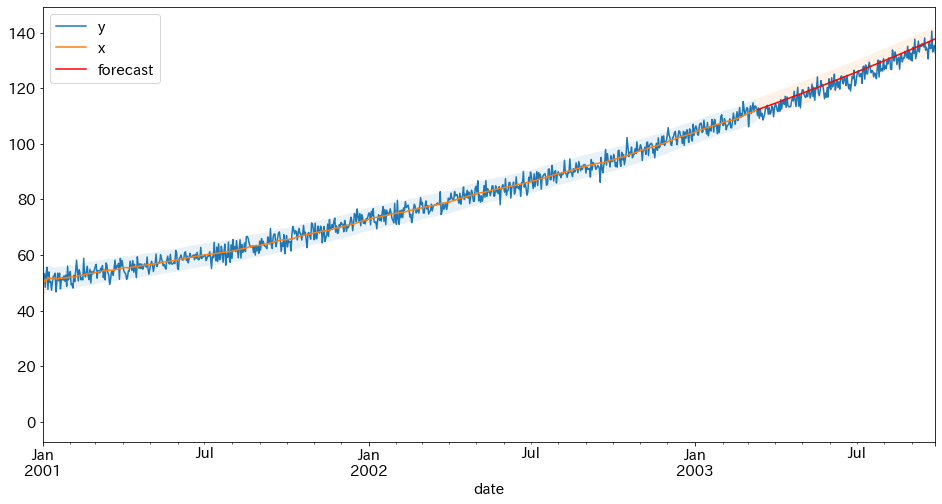

In [132]:
fig, ax = plt.subplots()

    
y = df['y']

# Plot the results
y.plot(ax=ax,label='y')
predict.predicted_mean.plot(label='x')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = predict_ci.index
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

forecast.predicted_mean.plot(ax=ax, style='r', label='forecast')
forecast_ci = forecast.conf_int()
forecast_index = forecast_ci.index
ax.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)

# Cleanup the image
legend = ax.legend(loc='best');
fig.savefig('custom_statespace.png')